# M5 Forecasting - Accuracy problem

The data used here is from [M5 Forecasting - Accuracy](https://www.kaggle.com/c/m5-forecasting-accuracy) problem on kaggle. There are three related datasets: 
- calendar.csv: date information
- sales_train_validation.csv: sales information of products in stores in 3 states: CA, TX and WI
- sell_prices.csv: price information of products

(We will see more about them below.)

The goal is to use the information in these 3 datasets to predict the sales of products in future days.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [2]:
INPUT_DIR = '/Users/tz/Desktop/sales'
cal = pd.read_csv(f'{INPUT_DIR}/calendar.csv') # calendar
stv = pd.read_csv(f'{INPUT_DIR}/sales_train_validation.csv') # sales
sellp = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv') # prices

# Exploratory Data Analysis

In [3]:
cal.head() # calendar
# besides information of the date, day of the week, the month, month of the year, the year, etc
# there is information of whether there is an event on that day and what kind of event it is
# snap_CA, snap_TX, snap_WI means whether that day is a 'snap' (Supplemental Nutrition Assistance Program (SNAP)) 
# day for stores in that state when people can buy food with shopping card sent out by the government

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [4]:
cal.describe()
# here we can see the range of these variables, year range: 2011 - 2016
# the info of 'date' and 'wm_yr_wk' is actually covered by other variables, so will be deleted in the future

,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI
count,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000
mean,11347.086338,3.997461,6.325546,2013.288471,0.330117,0.330117,0.330117
std,155.277043,2.001141,3.416864,1.580198,0.470374,0.470374,0.470374
min,11101.000000,1.000000,1.000000,2011.000000,0.000000,0.000000,0.000000
25%,11219.000000,2.000000,3.000000,2012.000000,0.000000,0.000000,0.000000
50%,11337.000000,4.000000,6.000000,2013.000000,0.000000,0.000000,0.000000
75%,11502.000000,6.000000,9.000000,2015.000000,1.000000,1.000000,1.000000
max,11621.000000,7.000000,12.000000,2016.000000,1.000000,1.000000,1.000000


In [5]:
cal[['event_name_1', 'event_type_1','event_name_2','event_type_2']].dropna()
# see some examples of 'event_name' and 'event_type'

,event_name_1,event_type_1,event_name_2,event_type_2
85,OrthodoxEaster,Religious,Easter,Cultural
827,OrthodoxEaster,Religious,Cinco De Mayo,Cultural
1177,Easter,Cultural,OrthodoxEaster,Religious
1233,NBAFinalsEnd,Sporting,Father's day,Cultural
1968,NBAFinalsEnd,Sporting,Father's day,Cultural


In [6]:
stv.head()   # sales
# here is how many items are sold each day for all items (identified by "id")
# for each item ('id'), these info is provided: category id ('cat_id'), department_id ('dept_id'), 
#                                                 item_id ('item_id')
# they are of a hierarchical relationship
# also which store it was sold at ('store_id') in which state ('state_id')
# Also you will notice 'id' is just all these info put together
# The story is that there are many stores in the 3 states: CA, TX and WI
# 
# "d_n" represents the day that item is sold on

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


In [7]:
stv['cat_id'].value_counts()

FOODS        14370
HOUSEHOLD    10470
HOBBIES       5650
Name: cat_id, dtype: int64

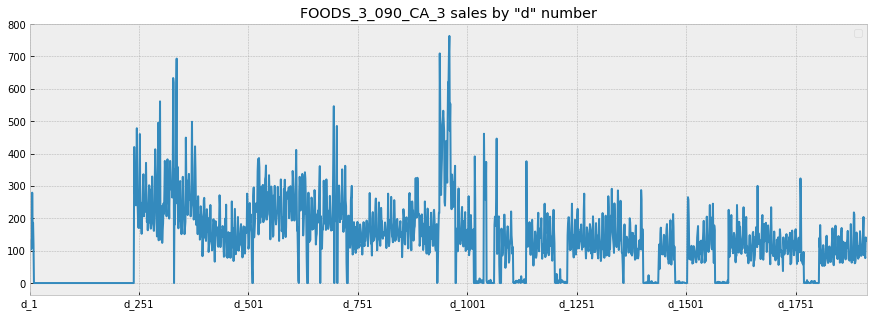

In [8]:
# visualize sales for some items
# 'FOODS_3_090_CA_3_validation'
d_cols = [c for c in stv.columns if 'd_' in c]
stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'] \
    .set_index('id')[d_cols] \
    .T \
    .plot(figsize=(15,5),
         title='FOODS_3_090_CA_3 sales by "d" number',
         color=next(color_cycle))
plt.legend('')
plt.show()

In [9]:
# plot the sales with real dates
# also the 'd_n' is linked to the real date
# via the 'd' column in 'calendar'
cal[['d','date']].head()

,d,date
0,d_1,2011-01-29
1,d_2,2011-01-30
2,d_3,2011-01-31
3,d_4,2011-02-01
4,d_5,2011-02-02


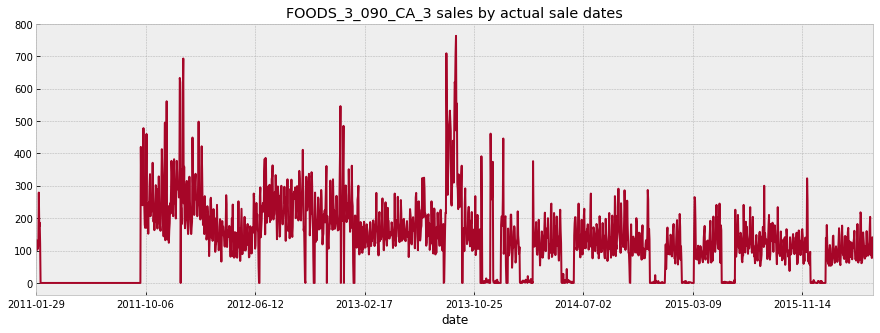

In [10]:
# plot the sales with real dates
example = stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'][d_cols].T
example = example.rename(columns={8412:'FOODS_3_090_CA_3'})
example = example.reset_index().rename(columns={'index':'d'})
example = example.merge(cal, how='left', validate='1:1')
example.set_index('date')['FOODS_3_090_CA_3'] \
    .plot(figsize = (15,5),
         color = next(color_cycle),
         title = 'FOODS_3_090_CA_3 sales by actual sale dates')
plt.show()

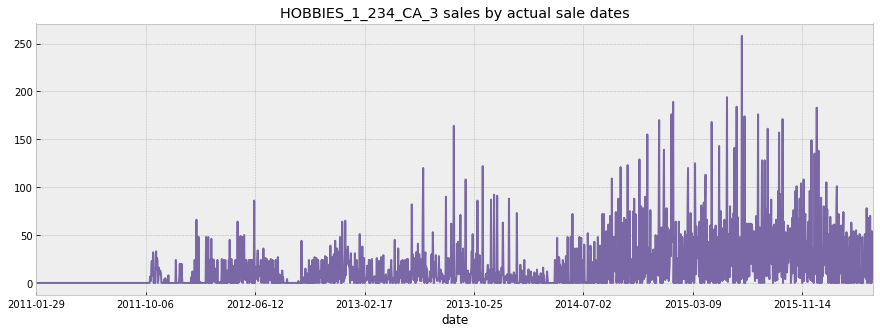

In [11]:
# visualize some other items
example2 = stv.loc[stv['id'] == 'HOBBIES_1_234_CA_3_validation'][d_cols].T
example2 = example2.rename(columns={6324:'HOBBIES_1_234_CA_3'})
example2 = example2.reset_index().rename(columns={'index':'d'})
example2 = example2.merge(cal, how='left', validate='1:1')
example2.set_index('date')['HOBBIES_1_234_CA_3'] \
    .plot(figsize = (15,5),
         color = next(color_cycle),
         title = 'HOBBIES_1_234_CA_3 sales by actual sale dates')
plt.show()

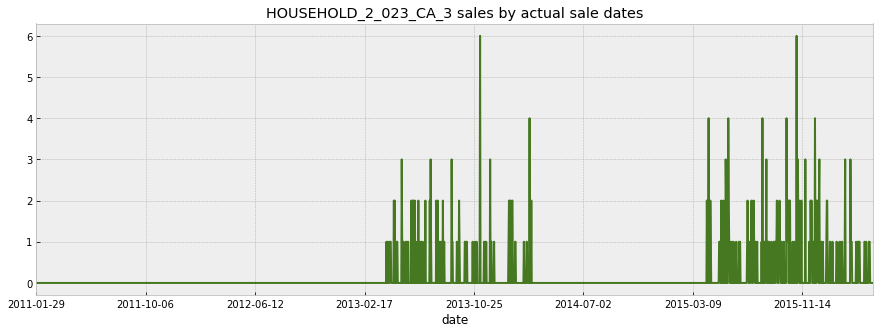

In [12]:
# visualize some other items
example3 = stv.loc[stv['id'] == 'HOUSEHOLD_2_023_CA_3_validation'][d_cols].T
example3 = example3.rename(columns={7217:'HOUSEHOLD_2_023_CA_3'})
example3 = example3.reset_index().rename(columns={'index':'d'})
example3 = example3.merge(cal, how='left', validate='1:1')
example3.set_index('date')['HOUSEHOLD_2_023_CA_3'] \
    .plot(figsize = (15,5),
         color = next(color_cycle),
         title = 'HOUSEHOLD_2_023_CA_3 sales by actual sale dates')
plt.show()

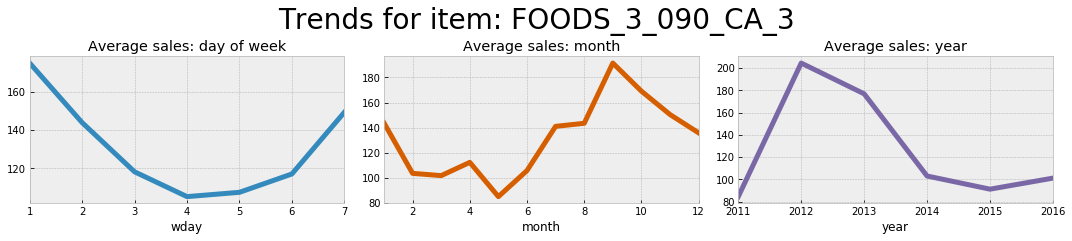

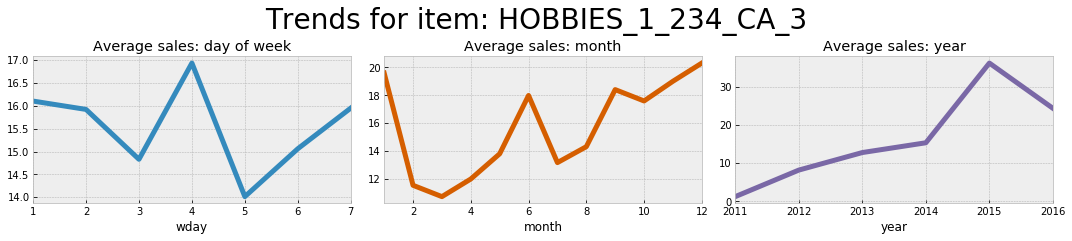

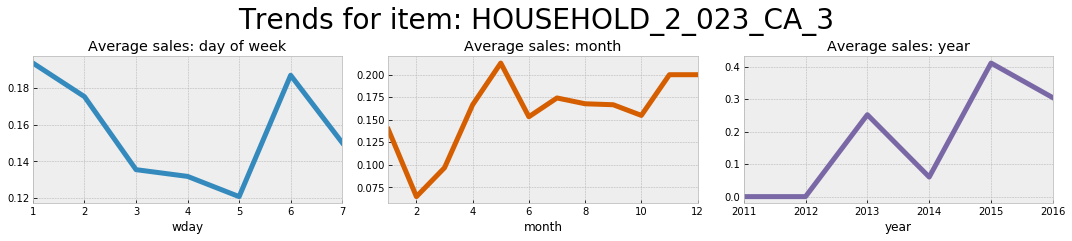

In [13]:
# see temporary trend of sales by week, month and year
examples = ['FOODS_3_090_CA_3', 'HOBBIES_1_234_CA_3', 'HOUSEHOLD_2_023_CA_3']
example_df = [example, example2, example3]
for i in [0,1,2]:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,3))
    example_df[i].groupby('wday').mean()[examples[i]] \
        .plot(kind='line',
             title='Average sales: day of week',
             lw=5,color=color_pal[0],
             ax=ax1)
    example_df[i].groupby('month').mean()[examples[i]] \
        .plot(kind='line',
             title='Average sales: month',
             lw=5,
             color=color_pal[4],
             ax=ax2)
    example_df[i].groupby('year').mean()[examples[i]] \
        .plot(kind='line',
             title='Average sales: year',
             lw=5,
             color=color_pal[2],
             ax=ax3)
    fig.suptitle(f'Trends for item: {examples[i]}', 
                size=28, y=1.1)
    plt.tight_layout()
    plt.show()

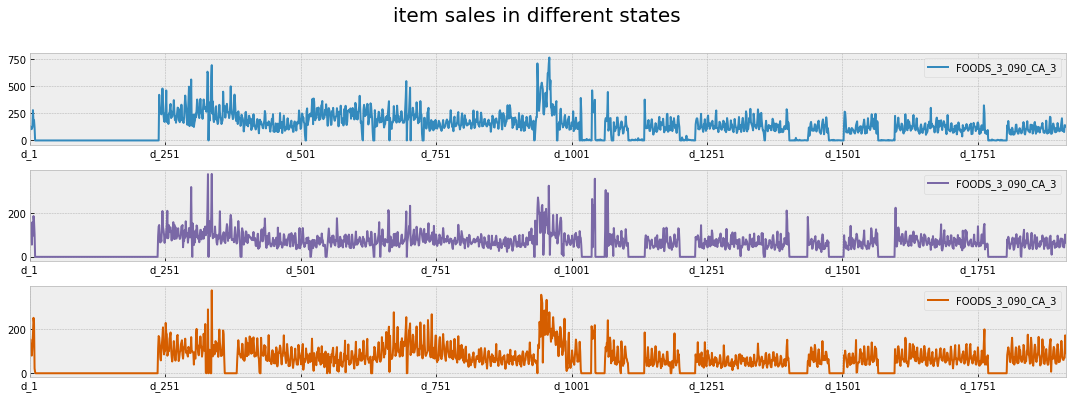

In [14]:
# see the sales trend of one item in different states
my_example1 = stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'][d_cols].T \
    .rename(columns={8412:'FOODS_3_090_CA_3'})
my_example2 = stv.loc[stv['id'] == 'FOODS_3_090_TX_3_validation'][d_cols].T \
    .rename(columns={20608:'FOODS_3_090_CA_3'})
my_example3 = stv.loc[stv['id'] == 'FOODS_3_090_WI_3_validation'][d_cols].T \
    .rename(columns={29755:'FOODS_3_090_CA_3'})
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,5))
my_example1.plot(kind='line',
                color=color_pal[0],
                ax=ax1)
my_example2.plot(kind='line',
                color=color_pal[2],
                ax=ax2)
my_example3.plot(kind='line',
                color=color_pal[4],
                ax=ax3)
fig.suptitle('item sales in different states',
            size=20,
            y=1.1)
plt.tight_layout()
plt.show()
# sales trends in different states are quite similar

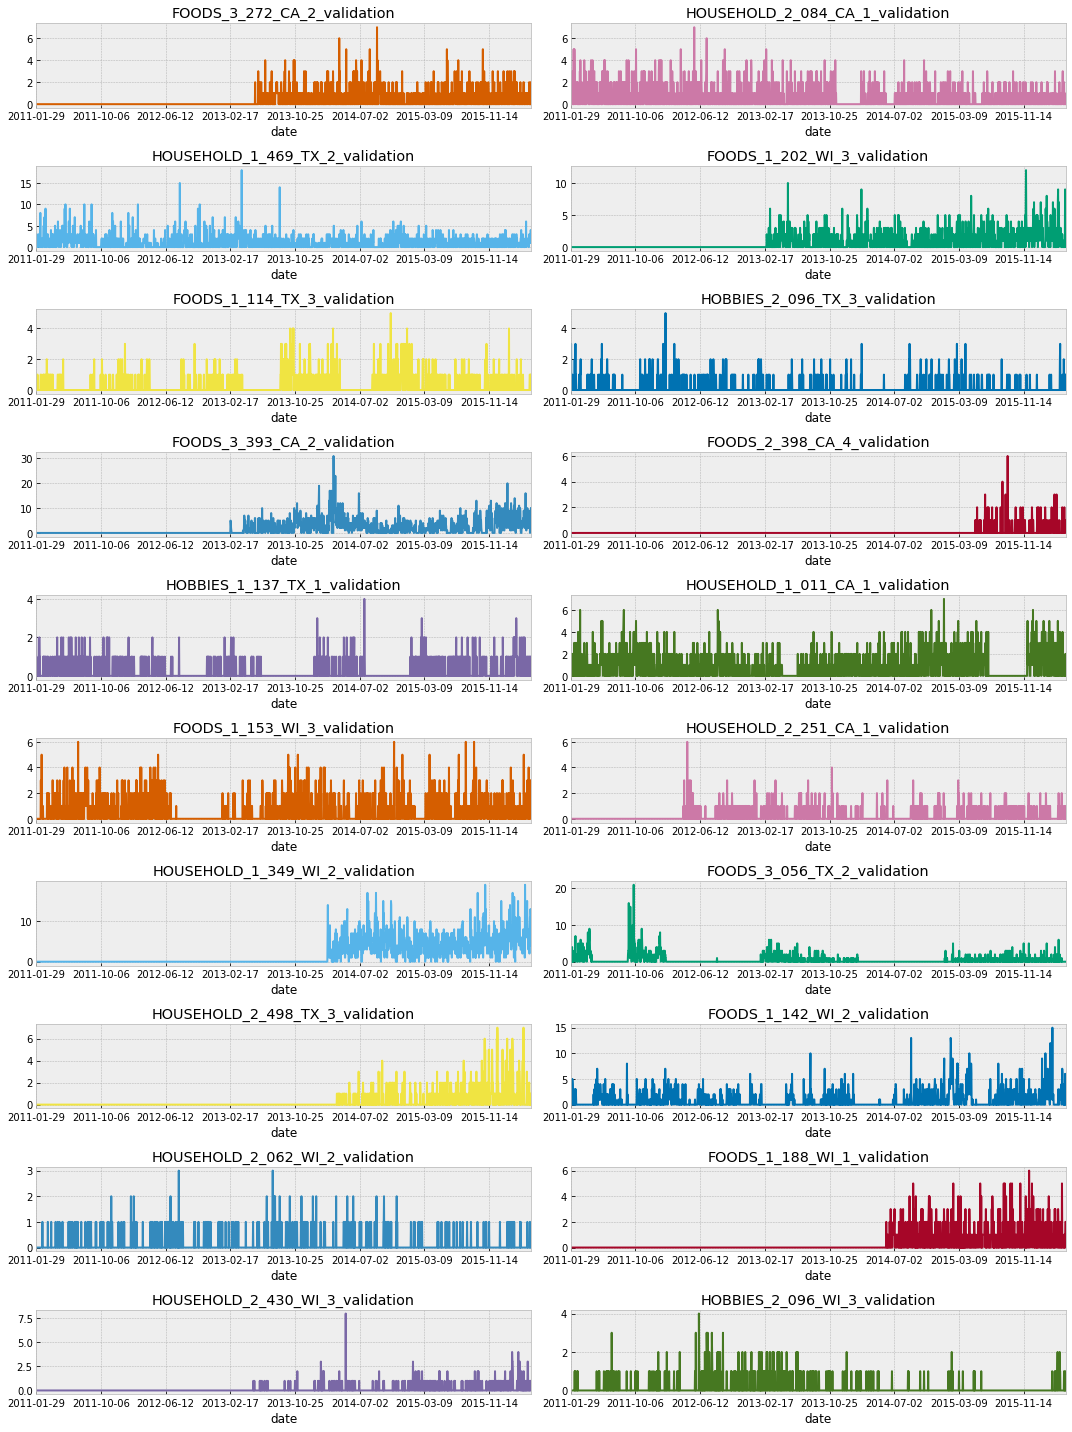

In [15]:
# look at sales of a lot of items
twenty_examples = stv.sample(20, random_state = 500) \
    .set_index('id')[d_cols].T \
    .merge(cal.set_index('d')['date'],
          left_index = True,
          right_index=True,
          validate='1:1') \
    .set_index('date')
fig,axs = plt.subplots(10, 2, figsize=(15,20))
axs = axs.flatten()
ax_idx = 0
for item in twenty_examples.columns:
    twenty_examples[item].plot(title = item,
                              color = next(color_cycle),
                              ax = axs[ax_idx])
    ax_idx += 1
plt.tight_layout()
plt.show()

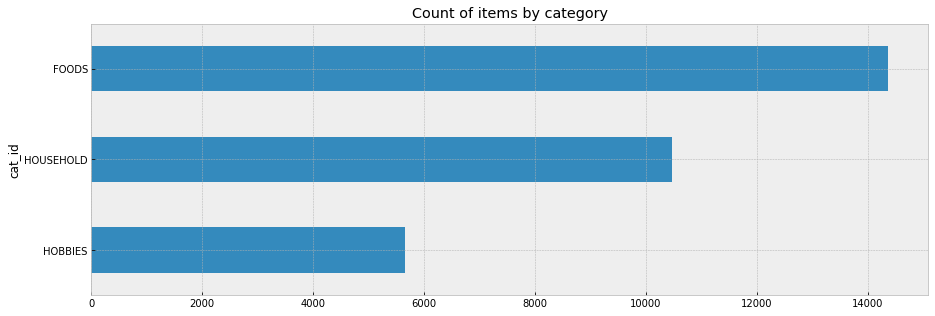

In [16]:
# see sales by category
stv.groupby('cat_id').count()['id'] \
    .sort_values() \
    .plot(kind='barh', figsize=(15,5), title='Count of items by category')
plt.show()

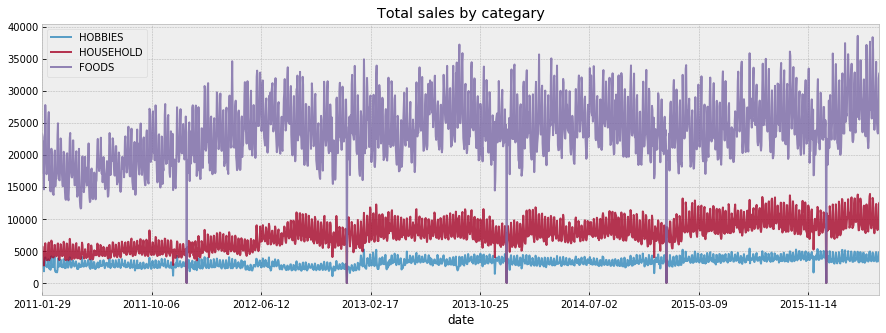

In [17]:
# sales trend by category
past_sales = stv.set_index('id')[d_cols] \
    .T \
    .merge(cal.set_index('d')['date'],
          left_index = True, 
          right_index = True,
          validate='1:1') \
    .set_index('date')
for i in stv['cat_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    past_sales[items_col] \
        .sum(axis=1) \
        .plot(figsize=(15,5),
             alpha=0.8,
             title='Total sales by categary')
plt.legend(stv['cat_id'].unique())
plt.show()
# There are much more sales of 'FOODS' than "HOUSEHOLD" than 'HOBBIES'
# There is always a drop in sales around Chrismas holidays

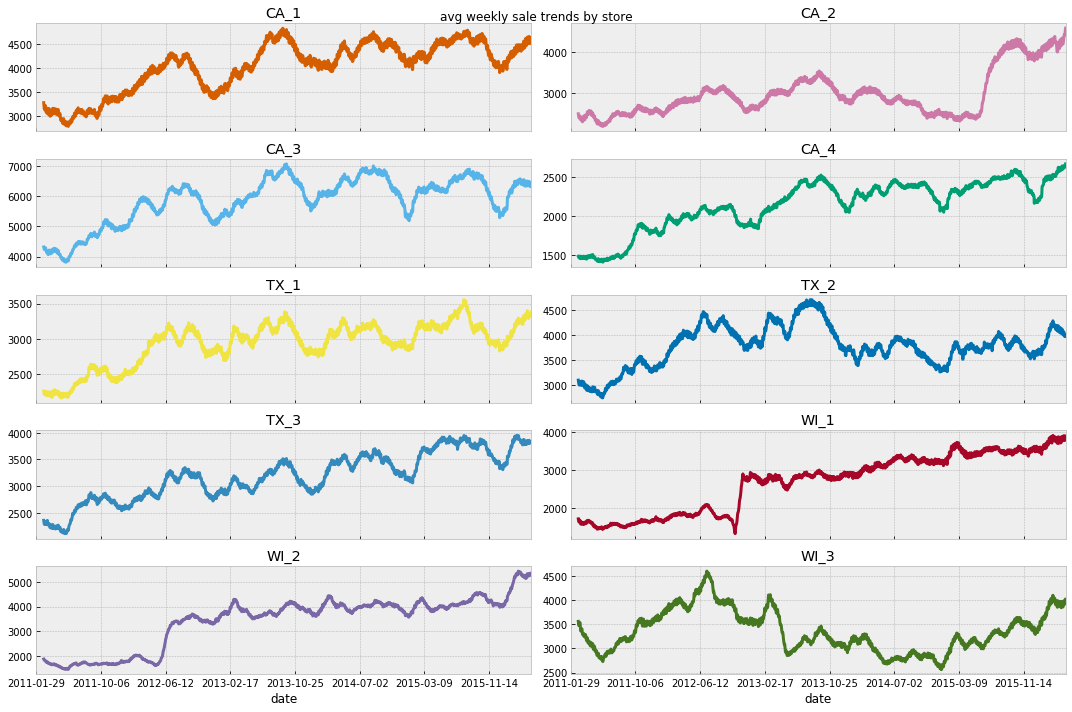

In [18]:
# sales trend (rolling 30 day average) by store
store_list = sellp['store_id'].unique()
fig, axes = plt.subplots(5, 2, figsize=(15,10), sharex=True)
axes = axes.flatten()
ax_idx = 0
for i in store_list:
    store_items = [c for c in past_sales.columns if i in c]
    past_sales[store_items] \
        .sum(axis=1) \
        .rolling(30).mean() \
        .plot(alpha=1, ax=axes[ax_idx],
             title=i,
             lw=3,
             color=next(color_cycle))
    ax_idx += 1
plt.suptitle('avg weekly sale trends by store')
plt.tight_layout()
plt.show()

In [19]:
# largest and smallest day sales
print('The date with lowest sale was ', past_sales.sum(axis=1).sort_values().index[0], 
    'with', past_sales.sum(axis=1).sort_values().values[0], 'sales')
print('The date with lowest sale was ', past_sales.sum(axis=1).sort_values() \
    .index[-1], 'with', past_sales.sum(axis=1).sort_values().values[-1], 'sales')

The date with lowest sale was  2012-12-25 with 11 sales
The date with lowest sale was  2016-03-06 with 57218 sales


In [20]:
sellp.head() # price data
# can use 'wm_yr_wk' to link to the 'calendar' dataset
# use 'store_id' and 'item_id' to link to the item and sales data in 'stv' dataset

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


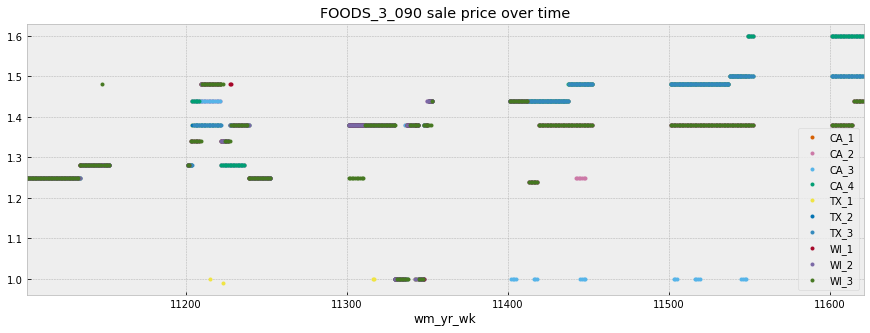

In [21]:
# sales price trend
fig, ax = plt.subplots(figsize=(15,5))
stores=[]
for store, d in sellp.query('item_id == "FOODS_3_090"').groupby('store_id'):
    d.plot(x = 'wm_yr_wk',
          y = 'sell_price',
          style = '.',
          color = next(color_cycle),
          figsize = (15,5),
          title = 'FOODS_3_090 sale price over time',
          ax = ax,
          legend = store)
    stores.append(store)
plt.legend(stores)
plt.show()

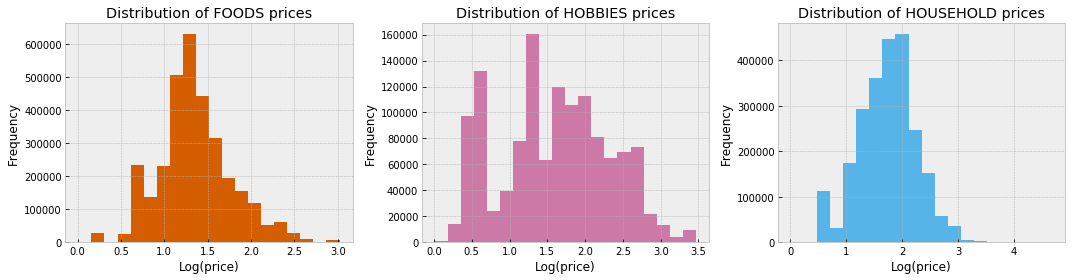

In [22]:
# price distribution
sellp['Category'] = sellp['item_id'].str.split('_', expand = True)[0]
fig, axs = plt.subplots(1, 3, figsize = (15,4))
i = 0
for cat, d in sellp.groupby('Category'):
    ax = d['sell_price'].apply(np.log1p) \
        .plot(kind='hist',
             bins=20,
             title=f'Distribution of {cat} prices',
             ax=axs[i],
             color=next(color_cycle))
    ax.set_xlabel('Log(price)')
    i += 1
plt.tight_layout()
plt.show()

# Data Preprocessing

In [23]:
# before passing the data into machine learning models, I need to preprocess data, i.e.,
# integrate 3 datasets into 1, keep useful features and drop useless ones
# process categorical data (one hot encoding)
# generate useful new features (lag, rolling avg)

In [24]:
cal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
date            1969 non-null object
wm_yr_wk        1969 non-null int64
weekday         1969 non-null object
wday            1969 non-null int64
month           1969 non-null int64
year            1969 non-null int64
d               1969 non-null object
event_name_1    162 non-null object
event_type_1    162 non-null object
event_name_2    5 non-null object
event_type_2    5 non-null object
snap_CA         1969 non-null int64
snap_TX         1969 non-null int64
snap_WI         1969 non-null int64
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


In [25]:
stv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


In [26]:
sellp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 5 columns):
store_id      object
item_id       object
wm_yr_wk      int64
sell_price    float64
Category      object
dtypes: float64(1), int64(1), object(3)
memory usage: 261.0+ MB


In [27]:
# since the datasets are too large to be merged, 
# I will only use data in year 2015
cal['date'] = pd.to_datetime(cal['date'])
cal = cal[(cal['date'] >= '01-01-2015') & (cal['date'] < '01-01-2016')]

In [28]:
catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
stv = pd.melt(stv, 
        id_vars = catcols,
       value_vars = [col for col in stv.columns if col.startswith("d_")],
       var_name = 'd', 
       value_name = 'sales') # wide to long 

In [29]:
df = stv.copy()
df = df.merge(cal,on = 'd', copy=False)

In [30]:
df = df.merge(sellp,how='left', on = ['store_id', 'item_id', 'wm_yr_wk'], copy=False)
del stv, cal, sellp

In [31]:
# create features: 
lags = [7, 28] # lag 1 week and lag 4 weeks
lag_cols = [f'lag_{lag}' for lag in lags]
for lag, lag_col in zip(lags, lag_cols):
    df[lag_col] = df[['id','sales']].groupby('id')['sales'].shift(lag)
    
wins = [7,28]   # rolling avg
for win in wins: 
    for lag, lag_col in zip(lags, lag_cols):
        df[f'rmean_{lag}_{win}'] = df[['id', lag_col]].groupby('id')[lag_col].transform(lambda x: x.rolling(win).mean())

In [32]:
df[['event_name_1','event_name_2','event_type_1','event_type_2']] = \
    df[['event_name_1','event_name_2','event_type_1','event_type_2']].fillna(value='0') # NaN means no event that day

In [33]:
df.shape

(11128850, 29)

In [34]:
# dataset too large, choose a random sample
df = df.sample(50000)

In [35]:
df.columns

Index(['id', 'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id', 'd',
       'sales', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'Category', 'lag_7',
       'lag_28', 'rmean_7_7', 'rmean_28_7', 'rmean_7_28', 'rmean_28_28'],
      dtype='object')

In [36]:
dummies = pd.get_dummies(df[['item_id','dept_id','cat_id', 'store_id','state_id', 'event_name_1', 'event_name_2', 'event_type_1', 'event_type_2']],
                        drop_first=True, 
                         prefix=['item_id','dept_id','cat_id', 'store_id', 'state_id', 'event_name_1', 'event_name_2', 'event_type_1', 'event_type_2'])

In [37]:
dummies.shape

(50000, 3101)

In [38]:
df = df.join(dummies)

In [39]:
df = df.dropna()
df['mday'] = getattr(df['date'].dt, 'day').astype("int16")
useless_cols = ['id', 'date', 'wm_yr_wk', 'weekday', 'd', 'sales', 'Category',
                'item_id','dept_id','cat_id','store_id','state_id','event_name_1','event_name_2','event_type_1','event_type_2']
y = df['sales']
X = df.drop(useless_cols, axis=1)
del df

In [40]:
X[:10]

,wday,month,year,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,item_id_FOODS_1_002,item_id_FOODS_1_003,item_id_FOODS_1_004,item_id_FOODS_1_005,item_id_FOODS_1_006,item_id_FOODS_1_008,item_id_FOODS_1_009,item_id_FOODS_1_010,item_id_FOODS_1_011,item_id_FOODS_1_012,item_id_FOODS_1_013,item_id_FOODS_1_014,...,event_name_1_LaborDay,event_name_1_LentStart,event_name_1_LentWeek2,event_name_1_MartinLutherKingDay,event_name_1_MemorialDay,event_name_1_Mother's day,event_name_1_NBAFinalsEnd,event_name_1_NBAFinalsStart,event_name_1_NewYear,event_name_1_OrthodoxChristmas,event_name_1_OrthodoxEaster,event_name_1_Pesach End,event_name_1_PresidentsDay,event_name_1_Purim End,event_name_1_Ramadan starts,event_name_1_StPatricksDay,event_name_1_SuperBowl,event_name_1_Thanksgiving,event_name_1_ValentinesDay,event_name_1_VeteransDay,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,mday
4378505,2,5,2015,0,0,0,5.77,5.0,2.0,3.857143,2.714286,3.035714,2.535714,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24
2364124,6,3,2015,0,0,0,1.97,0.0,0.0,0.571429,0.285714,0.285714,0.142857,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19
5700622,3,7,2015,1,1,1,1.96,0.0,0.0,0.000000,0.000000,0.000000,0.464286,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
8395313,1,10,2015,1,1,1,5.27,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
9746147,3,11,2015,0,0,0,4.97,0.0,0.0,0.142857,0.000000,0.142857,0.250000,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16
8187899,1,9,2015,0,0,0,1.24,0.0,3.0,0.714286,0.571429,0.928571,1.250000,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26
9466310,1,11,2015,1,1,0,2.98,2.0,5.0,1.428571,2.000000,1.392857,1.464286,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7
6433965,7,7,2015,0,0,0,4.63,0.0,0.0,0.000000,1.428571,0.357143,1.535714,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31
6550723,3,8,2015,1,1,1,3.82,0.0,3.0,0.571429,1.428571,0.785714,0.785714,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
9166504,5,10,2015,0,0,0,5.94,0.0,0.0,0.285714,0.142857,0.250000,0.357143,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28


In [41]:
X.shape

(42282, 3115)

# Modeling

### Look at performance of several machine learning models

In [42]:
# the models we will be looking at are:
# linear regression
# support vector regression (SVR)
# RandomForest
# AdaBoost

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
pipe_mlr = make_pipeline(LinearRegression())
scores_mlr = cross_val_score(estimator=pipe_mlr,
                        X=X,
                        y=y,
                        cv=5,
                        n_jobs=3)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores_mlr), np.std(scores_mlr)))

CV accuracy: 0.589 +/- 0.040


In [ ]:
from sklearn.svm import SVR
pipe_svr = make_pipeline(SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1))
scores_svr = cross_val_score(estimator=pipe_svr,
                        X=X,
                        y=y,
                        cv=5,
                        n_jobs=3)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores_svr), np.std(scores_svr)))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
pipe_rf = make_pipeline(RandomForestRegressor(n_estimators=100,
                                              max_depth=3,
                                              random_state=1))
scores_rf = cross_val_score(estimator=pipe_rf,
                        X=X,
                        y=y,
                        cv=5,
                        n_jobs=3)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores_rf), np.std(scores_rf)))

In [ ]:
import sklearn
sklearn.metrics.SCORERS.keys()

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
pipe_ada = make_pipeline(AdaBoostRegressor(n_estimators=100,
                                              random_state=1))
scores_ada = cross_val_score(estimator=pipe_ada,
                        X=X,
                        y=y,
                        cv=5,
                        n_jobs=3,
                            scoring='r2')
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores_ada), np.std(scores_ada)))

### Learning curve and parameter grid search

In [ ]:
# from the above experiments, we can see model '' has the best performance
# look at its learning curve

from sklearn.model_selection import learning_curve

pipe_best = pipe_rf

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_best,
                  X=X,
                  y=y,
                  train_sizes=np.linspace(0.1,1.0,10),
                  cv=5,
                  n_jobs=3)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean,
        color='b',marker='o',
        markersize=5,label='Training accuracy')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std,
                alpha=0.15,color='b')
plt.plot(train_sizes, test_mean,color='g',
        linestyle='--',
        marker='s',markersize=5,
        label='Validation accuracy')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std,
                alpha=0.15,color='g')
plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
pipe_best.get_params()

In [ ]:
# Using grid search to find the best parameters
from sklearn.model_selection import GridSearchCV

param_grid = { 
    'randomforestregressor__n_estimators': [25, 50, 100, 200],
#     'randomforestregressor__max_features': ['auto', 'sqrt', 'log2'],
    'randomforestregressor__max_depth' : [1, 2, 3, 5, 7] #,6,7,8],
}
# param_range = [0.0001, 0.001, 0.01, 0.1,
#               1.0, 10.0, 100.0, 1000.0]
# param_grid=[{'svc__C':param_range,
#             'svc__kernel':['linear']},
#            {'svc__C':param_range,
#            'svc__gamma':param_range,
#            'svc__kernel':['rbf']}]
gs = GridSearchCV(estimator=pipe_best,
                 param_grid=param_grid,
                 scoring='r2',
                 cv=5,
                 refit=True,
                 n_jobs=3)
gs = gs.fit(X, y)
print(gs.best_score_)
print(gs.best_params_)

# Deep learning

In [ ]:
import tensorflow as tf
tf.random.set_seed(1)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=4,
                               input_shape=(X.shape[1],),
                               activation='sigmoid'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
model.summary()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   random_state=1,
                                                   train_size=0.5)
model.compile(optimizer=tf.keras.optimizers.SGD(),
             loss='mean_squared_error',
             metrics=['mse'])
hist = model.fit(X_train, y_train,
                validation_data=(X_test, y_test),
#                 epochs=200, batch_size=10, verbose=0)
                epochs=10, batch_size=10, verbose=0)

In [ ]:
from mlxtend.plotting import plot_decision_regions
history = hist.history
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(1,2,1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train_loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1,2,2)
plt.plot(history['mse'], lw=4)
plt.plot(history['val_mse'], lw=4)
plt.legend(['Train MSE', 'Validation MSE'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
plt.show()